# MTH 651: Advanced Numerical Analysis

## Lecture 10

### Topics

* Discrete variational problems and SPD matrices

#### Variational Formulation for $L^2$ Projection

We saw how to use MFEM to compute interpolants to approximate functions.

Let's look at another way of approximating an arbitrary function.

Let $f \in L^2(\Omega)$.

We want to find $u_h \in V_h$ such that
$$
    \| u_h - f \|_{L^2(\Omega)} = \min_{v \in V_h} \| v - f \|_{L^2(\Omega)}.
$$

How can we use the ideas of **variational formulations** and **Galerkin orthogonality** to find such a $u_h$?

First of all, why did we write $\min$ instead of $\inf$?

In other words, why do we know that a minimizer exists?

Define the bilinear form $m(\cdot, \cdot)$ by
$$
    m(u, v) = (u, v)
$$
i.e. $m(\cdot, \cdot)$ is just the standard $L^2$ inner product.

Let $f \in L^2(\Omega)$ be given.

> Find $u_h \in V_h$ such that
> $$ m(u_h, v) = (f, v) $$
> for all $v \in V_h$.

> **_PROPOSITION:_** (Galerkin orthogonality). The error $u_h - f$ is orthogonal (in the $L^2$ inner product) to all of $V_h$

> _Proof._ 
> $$
>   (u_h - f, v) = (u_h, v) - (f, v) = 0.
> $$

> **_PROPOSITION:_** $\| u_h - f \|_{L^2(\Omega)} = \min_{v \in V_h} \| v - f \|_{L^2(\Omega)}$.

> _Proof._ This is a consequence of Galerkin orthogonality.

We should notice that all of the above results are **completely analogous** to those that we have shown previously for the variational form of the Poisson problem.
(In fact, we proved the more abstract version for any coercive and continuous bilinear form — the form $m(\cdot, \cdot)$ is trivially coercive and continuous with constants 1).

The bilinear form $m(\cdot, \cdot)$ induces an **associated system matrix**.

Let $\phi_i$ denote the global basis functions.

Define the **mass matrix**

$$
    M_{ij} = m(\phi_i, \phi_j)
$$

Define the vector $F$ by

$$
    F_i = (f, v_i)
$$

Then, the variational problem is equation to the following linear system of equations

$$
    M U = F
$$

where the vector $U$ represents the coefficients of $u_h$ expanded in the basis $\phi_i$.

In [1]:
# Import MFEM and GLVis, define a coefficient...

import mfem.ser as mfem
from glvis import glvis

from math import cos, exp, sin

class f(mfem.PyCoefficient):
    def EvalValue(self, xvec):
        x = xvec[0]
        y = xvec[1]
        return exp(0.1*sin(5.1*x - 6.2*y) + 0.3*cos(4.3*x +3.4*y))

In [2]:
# Create the mesh and finite element space
mesh = mfem.Mesh(20, 20, "TRIANGLE")
order_k = 2
fe_collection = mfem.H1_FECollection(order_k, mesh.Dimension())
fe_space = mfem.FiniteElementSpace(mesh, fe_collection)

# 5. Define the solution x as a finite element grid function in fespace. Set
#    the initial guess to zero, which also sets the boundary conditions.
u = mfem.GridFunction(fe_space)

# Create the right-hand side vector using the linear form F : v -> (f, v)
# This is called a "domain linear form integrator", or DomainLFIntegrator
F = mfem.LinearForm(fe_space)
F.AddDomainIntegrator(mfem.DomainLFIntegrator(f()))
# F.Assemble() tells MFEM to actually compute the entries of the vector F
F.Assemble()

# Set up the bilinear form m(.,.). The L2 inner product is called a
# "mass integrator"
m = mfem.BilinearForm(fe_space)
m.AddDomainIntegrator(mfem.MassIntegrator())
m.Assemble()
m.Finalize()

# Get the matrix associated with the bilinear form
M = m.SpMat()


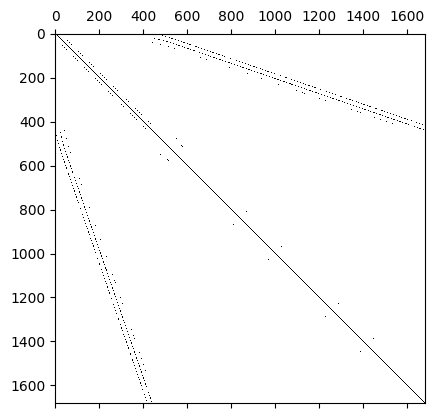

In [3]:
from mfem.common.sparse_utils import sparsemat_to_scipycsr
import matplotlib.pyplot as plt

plt.spy(sparsemat_to_scipycsr(M, float).todense())

In [4]:
GS = mfem.GSSmoother(M)
u.Assign(0.0)
mfem.PCG(M, GS, F, u, 1, 200, 1e-12, 0.0)

   Iteration :   0  (B r, r) = 0.817362
   Iteration :   1  (B r, r) = 0.00437464
   Iteration :   2  (B r, r) = 4.9583e-05
   Iteration :   3  (B r, r) = 4.49892e-07
   Iteration :   4  (B r, r) = 9.59129e-09
   Iteration :   5  (B r, r) = 1.95933e-10
   Iteration :   6  (B r, r) = 2.20306e-12
   Iteration :   7  (B r, r) = 1.11426e-14
Average reduction factor = 0.102238


In [5]:
glvis((mesh, u))

glvis(data_str='MFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see mesh/geom.hpp):\n#\n# POINT       = 0\n# SEGME…

### Properties of the mass matrix

First, $M$ is symmetric. (Why?)

> **_DEFINITION:_** A symmetric matrix $A$ is called **positive definite** if
>
> * $v^T A v \geq 0$ for all $v$
> * $v^T A v = 0$ only when $v = 0$
>
> If only the first condition holds, the matrix is called **positive semidefinite**

> **_PROPOSITION:_** $M$ is positive definite. (Why)?

> **_PROPOSITION:_** A symmetric matrix $A$ is positive definite iff all of its eigenvalues are positive.

First, we should recall that a symmetric matrix (Hermetian, even) has only real eigenvalues.

To see this, suppose $A^* = A$, and let $A v = \lambda v$.
Then, $v^* A v = \lambda v^* v = \lambda \| v \|^2$, and
$$
    \lambda^* \| v \|^2 = (v^* A v)^* = v^* A^* v = v^* A v = \lambda \| v \|^2,
$$
so $\lambda = \lambda^*$ and $\lambda \in \mathbb{R}$.

Now, suppose $A$ is positive definite.
Let $v$ be an eigenvector.
Then,
$$
    0 < v^T A v = \lambda \| v \|^2,
$$
so $\lambda > 0$.

Now, suppose that $A$ has only positive eigenvalues.
Then, by the spectral theorem,
$$
    A = Q^T \Lambda Q,
$$
where $Q$ is orthogonal (i.e. $Q^T = Q^{-1}$), and $\Lambda = \operatorname{diag}(\lambda_1, \lambda_2, \ldots, \lambda_n)$.
Then, for any $v$, let $w = Q v$, i.e. $v = Q^{-1} w$.
So,
$$
    v^T A v = (Q^{-1} w)^T A Q^{-1} w = w^T Q^{-T} Q^T \Lambda Q Q^{-1} w = w^T \Lambda w > 0
$$

The fact that $M$ is SPD (symmetric and positive definite) makes the linear system of equations
$$
    M U = F
$$
much easier to solve.
Such systems are more amenable to solution by numerical methods, both direct and iterative.
In particular,

* Direct: can use Cholesky instead of LU
* Iterative:
    * Gauss-Seidel
    * (Better:) (preconditioned) conjugate gradient

### Stationary Methods

Let $A$ be a given matrix.
We want to solve
$$
    A x = b
$$
for some right-hand side $b$.
Suppose we cannot invert $A$ (e.g. because it is too large).

There are a class of **iterative methods** for approximating the solution $x$ called **stationary methods**.
These methods are based on the general iteration
$$
    x^{(i+1)} = x^{(i)} + B(b - A x^{(i)})
$$
for some **fixed** non-singular matrix $B$.

We can consider this as a fixed-point iteration
$$
    x^{(i+1)} = \Phi(x^{(i)}),
$$
where the iteration operator $\Phi$ is defined by
$$
    \Phi(z) = z + B(b - A z).
$$

Suppose $x$ is a fixed point of $\Phi$, i.e. $\Phi(x) = x$.
Then,
$$
    x = x + B(b - A x)
$$
and we obtain
$$
    B A x = B b,
$$
and (since $B$ is nonsingular), this implies that
$$
    Ax = b,
$$
and $x$ is the solution to our problem.

Therefore, solving the problem $Ax = b$ is equivalent to finding a fixed point of $\Phi$.

The iteration
$$
    x^{(i+1)} = \Phi(x^{(i)}),
$$
converges to a fixed point of $\Phi$ .

We know that if $\Phi$ is a **contraction mapping**, then this iteration will converge to the unique fixed point.

> **_RECALL:_** We say $\Phi$ is **contraction mapping** if it brings any two points "closer together," i.e., for any $x$ and $y$
> $$
>   \| \Phi(x) - \Phi(y) \| \leq c \| x - y \|,
> $$
> with $c < 1$.

Note that our operator is $\Phi : z \mapsto z + B(b - Az)$, and so
$$
    \Phi(x) - \Phi(y) = x + Bb - BAx - y - Bb + BAy = (I - BA)(x - y).
$$
This means that $\Phi$ is a contraction mapping whenever the norm of $(I - BA)$ is less than one.

#### Gauss-Seidel method

Decompose $A = L + U$, where

* $L$ is lower-triangular
* $U$ is **strictly** upper-triangular (zeros on the diagonal)

The main idea is to approximate $A$ by its lower-triangular part (we could equally well use the upper-triangular part --- in our case, the matrix is symmetric, so it doesn't matter).

We start with an initial guess $x^{(0)}$.
This guess is not in general exact, so we have some **residual**
$$
    r^{(0)} = b - A x^{(0)}
$$

**If** we could invert $A$, and solve for the **error**
$$
    e^{(0)} = A^{-1} r^{(0)}
$$
then we can check
$$
    x = x^{(0)} + e^{(0)}
$$
since
$$
    A (x^{(0)} + e^{(0)}) = A x^{(0)} + r^{(0)} = b.
$$

But, we can approximate $e^{(0)}$ using the lower-triangular part $L$, and then iterate, i.e.
$$
    x^{(1)} = x^{(0)} + L^{-1} r^{(0)}
$$
We can see that this iteration results in
$$
    x^{(1)} = L^{-1} ( b - U x^{(0)} ).
$$
Another way of obtaining the same iteration is to write
$$
    Ax = (L + U) x = b
$$
and split the left-hand side to get
$$
    Lx = b - Ux,
$$
and use the "previous" guess for the right-hand side.

In general, the iteration is
$$
    x^{(i+1)} = L^{-1} ( b - Ux^{(i)})
$$

Consider a simple example of a $3 \times 3$ matrix,
$$
    \begin{pmatrix}
    a_{11} & a_{12} & a_{13} \\
    a_{21} & a_{22} & a_{23} \\
    a_{31} & a_{32} & a_{33} \\
    \end{pmatrix}
    \begin{pmatrix} x_1 \\ x_2 \\ x_3 \end{pmatrix}
    =
    \begin{pmatrix} b_1 \\ b_2 \\ b_3 \end{pmatrix}.
$$

Suppose we are given an initial guess $(x_1^{(i)}, x_2^{(i)}, x_3^{(i)})$.
Then, the Gauss-Seidel iteration improves on this guess by:

1. Keeping $x_2^{(i)}$ and $x_3^{(i)}$ fixed, and then solving for $x_1^{(i+1)}$.
2. Now we have an improved $x_1^{(i+1)}$, so use $x_1^{(i+1)}$ and $x_3^{(i)}$ to solve for $x_2^{(i+1)}$.
3. Now use the improved values $x_1^{(i+1)}$ and $x_2^{(i+1)}$ to solve for $x_3^{(i+1)}$

This can be written as
$$
    \begin{pmatrix}
    a_{11} & 0 & 0 \\
    a_{21} & a_{22} & 0 \\
    a_{31} & a_{32} & a_{33} \\
    \end{pmatrix}
    \begin{pmatrix} x_1^{(i+1)} \\ x_2^{(i+1)} \\ x_3^{(i+1)} \end{pmatrix}
    + 
    \begin{pmatrix}
    0 & a_{12} & a_{13} \\
    0 & 0 & a_{23} \\
    0 & 0 & 0 \\
    \end{pmatrix}
    \begin{pmatrix} x_1^{(i)} \\ x_2^{(i)} \\ x_3^{(i)} \end{pmatrix}
    =
    \begin{pmatrix} b_1 \\ b_2 \\ b_3 \end{pmatrix}.
$$

It is easy to see that the general form of this iteration is
$$
    L x^{(i+1)} + U x^{(i)} = b,
$$
which is the Gauss-Seidel method.

This can be viewed as a **fixed-point iteration**, let $\Phi$ be the iteration operator, i.e.
$$
    \Phi(v) = L^{-1}(b - Ux).
$$
It is easy to see that a **fixed point** of $\Phi$ is a solution to $A x = b$.

The iteration has a unique fixed point if $\Phi$ is a contraction mapping, i.e. if the iteration matrix $\| -L^{-1} U \| < 1$ in some (any!) norm.

(Note that $-L^{-1} U = -L^{-1} (A - L) = I - L^{-1} A$).

Another way of seeing this is to consider the error at step $i+1$

$$
\begin{aligned}
    e^{(i+1)} &= x^{(i+1)} - x \\
        &= L^{-1}(b - Ux^{(i)}) - x \\
        &= L^{-1}(b - (A - L)x^{(i)}) - x \\
        &= L^{-1}b - L^{-1} A x^{(i)} + x^{(i)} - x \\
        &= L^{-1} A x - L^{-1} A x^{(i)} + x^{(i)} - x \\
        &= (I - L^{-1} A)(x^{(i)} - x) \\
        &= (I - L^{-1} A)(e^{(i)}) \\
\end{aligned}
$$

and so

$$
    e^{(i+1)} = (I - L^{-1} A)^{i+1} e^{(0)}
$$

hence

$$
    \| e^{(i+1)} \| \leq \| I - L^{-1} A \|^{i+1}  \| e^{(0)} \|
$$
in **any** norm

Now, we want to show that $I - L^{-1} A$ has norm less than one.

First, we note that if $A$ is SPD, then $A$ induces a norm
$$
    \| x \|_A^2 = x^T A x.
$$

Then, consider the norm of $\| I - L^{-1} A \|_A$.
The statement $\| I - L^{-1} A \|_A < 1$ is equivalent to
$$
    ((I - L^{-1}A)x)^T A ((I - L^{-1}A) x) < x^T A x
$$
for all $x$, or
$$
    x^T A x - ((I - L^{-1}A)x)^T A ((I - L^{-1}A) x) > 0.
$$
Expanding
$$
    \begin{aligned}
        x^T A x - (x^T - x^T A L^{-T}) A (x - L^{-1}A x) 
            &= x^T A x - x^T (I - A L^{-T}) A (I - L^{-1}A ) x \\
            &= x^T A x - x^T (A - A L^{-T} A) (I - L^{-1}A ) x \\
            &= x^T A x - x^T (A - A L^{-T} A - A L^{-1}A + A L^{-T} A L^{-1}A ) x \\
            &= x^T (A L^{-T} A + A L^{-1}A - A L^{-T} A L^{-1}A ) x \\
            &= x^T A^T (L^{-T} + L^{-1} - L^{-T} A L^{-1} ) A x \\
            &= x^T A^T L^{-T} (L + L^T - A ) L^{-1} A x
    \end{aligned}
$$
If $L + L^T - A$ is SPD, then the inequality holds.

Note that $L + L^T - A$ is the diagonal of $A$, and if $A$ is SPD, then it's diagonal must also be SPD.

So, the inequality holds, and we conclude that Gauss-Seidel converges when applied to **any** SPD matrix.

In MFEM, this class of fixed-point iteration solvers are called "stationary linear iterations" (SLI).

The general form is

$$
    x^{(i+1)} = x^{(i)} + B (b - Ax^{(i)}),
$$

so for Gauss-Seidel this is given by $B = L^{-1}$.

In [6]:
Linv = mfem.GSSmoother(M)
GS = mfem.SLISolver()
GS.SetPreconditioner(Linv)
GS.SetOperator(M)
GS.SetRelTol(1e-10)
GS.SetPrintLevel(1)
GS.SetMaxIter(100)
u.Assign(0.0)
GS.Mult(F,u)

   Iteration :   0  ||Br|| = 32.2015
   Iteration :   1  ||Br|| = 7.79566    	Conv. rate: 7.79566
   Iteration :   2  ||Br|| = 1.67135    	Conv. rate: 0.214394
   Iteration :   3  ||Br|| = 0.386499   	Conv. rate: 0.23125
   Iteration :   4  ||Br|| = 0.100165   	Conv. rate: 0.25916
   Iteration :   5  ||Br|| = 0.0288377  	Conv. rate: 0.287902
   Iteration :   6  ||Br|| = 0.00899321 	Conv. rate: 0.311856
   Iteration :   7  ||Br|| = 0.00296643 	Conv. rate: 0.329853
   Iteration :   8  ||Br|| = 0.00101765 	Conv. rate: 0.343057
   Iteration :   9  ||Br|| = 0.000359001	Conv. rate: 0.352773
   Iteration :  10  ||Br|| = 0.000129205	Conv. rate: 0.359901
   Iteration :  11  ||Br|| = 4.71679e-05	Conv. rate: 0.365063
   Iteration :  12  ||Br|| = 1.73928e-05	Conv. rate: 0.368743
   Iteration :  13  ||Br|| = 6.45859e-06	Conv. rate: 0.371336
   Iteration :  14  ||Br|| = 2.41006e-06	Conv. rate: 0.373155
   Iteration :  15  ||Br|| = 9.02416e-07	Conv. rate: 0.374437
   Iteration :  16  ||Br|| = 3.38726

### Cost model for dense and sparse linear algebra

Does Gauss-Seidel really provide any benefits over just doing (naive, dense) Gaussian elimination?

We can store a matrix $M$ in a number of ways.

For example, we can store $M$ as a **dense matrix**, i.e. as an array of shape $n \times n$ (for a square matrix, generalization to rectangular is immediate).
This requires $n^2$ storage.

However, if **most** of the entries of $M$ are zero, we can improve on this storage cost.
For example, we could represent $M$ as follows:

> $M$ is an $n \times n$ matrix with non-zero entries $(i_1, j_1, a_1), (i_2, j_2, a_2), \ldots, (i_{\mathrm{nnz}}, j_{\mathrm{nnz}}, a_{\mathrm{nnz}})$.

This is a sparse matrix format called **coordinate format**.
You just need to know the dimension of the matrix, and have a list of the nonzeros (and their coordinates).
So, the storage is $\sim 3 \mathrm{nnz} = \mathcal{O}( \mathrm{nnz})$.
If $\mathrm{nnz} \ll n$ then this is big savings!

In [7]:
def nnz_mass_matrix(n):
    # Create the mesh and finite element space
    mesh = mfem.Mesh(n, n, "TRIANGLE")
    order_k = 1
    fe_collection = mfem.H1_FECollection(order_k, mesh.Dimension())
    fe_space = mfem.FiniteElementSpace(mesh, fe_collection)
    m = mfem.BilinearForm(fe_space)
    m.AddDomainIntegrator(mfem.MassIntegrator())
    m.Assemble()
    m.Finalize()
    M = m.SpMat()
    return (M.Width(), M.NumNonZeroElems())

In [8]:
import numpy as np
import matplotlib.pyplot as plt

nrefinements = 6

nnzs = np.zeros(nrefinements)
ns = np.zeros(nrefinements)
mesh_size = 4

for i in range(nrefinements):
    ns[i], nnzs[i] = nnz_mass_matrix(mesh_size)
    mesh_size *= 2


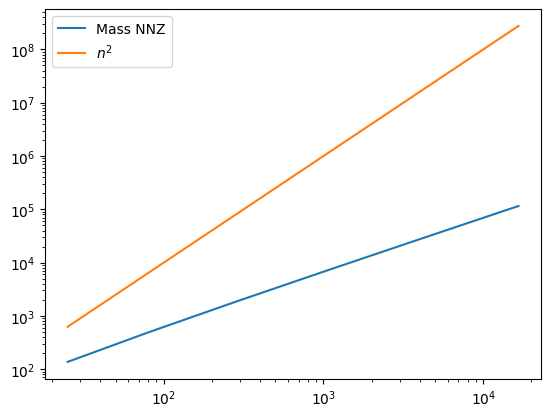

In [9]:
plt.loglog(ns, nnzs, label="Mass NNZ")
plt.loglog(ns, ns**2, label="$n^2$")
plt.legend()

In [10]:
np.log(nnzs[-1]/nnzs[-2]) / np.log(ns[-1]/ns[-2])

1.0064109694630328

So, we can see that the number of nonzeros in the mass matrix scales like $\mathcal{O}(n)$ (with $h$-refinement).
So, storing $M$ as a sparse matrix instead of a dense matrix gives a memory usage speedup from $\mathcal{O}(n^2)$ to $\mathcal{O}(n)$.

In practice, coordinate format is not always so convenient, we use other formats called **compressed sparse row** or **compressed sparse column**, but the details are not so important right now.

### Computational Complexities

#### Gaussian elimination

Gaussian elimination requires $\mathcal{O}(n)$ vector operations for every row.
Each vector operator requires $\mathcal{O}(n)$ floating point operators, so $\mathcal{O}(n^2)$ floating point operations per row.
This gives a total of $\mathcal{O}(n^3)$ floating point operations for Gaussian elimination.

#### Matrix-vector products

On the other hand, if we look at a matrix-vector product $y = Ax$,

$$
    y_i = \sum_{j=1}^n A_{ij} x_j,
$$
this is $n$ operations per row, so $\mathcal{O}(n^2)$ total.
However, we can **skip** any zero entries of $A$, and so if $A$ is stored in sparse format, the complexity becomes
$$
    \mathcal{O}(\mathrm{nnz}).
$$

Similarly for inverting a lower-triangular sparse matrix (i.e. forward substitution).

So, for each iteration of Gauss-Seidel, we perform one matrix-vector product and one forward-solve (and some vector operations), so the cost per iteration scales like
$$
    \mathcal{O}(\mathrm{nnz})
$$
(we assume that $\mathcal{nnz} \gtrsim n$).

Therefore, the total computational cost of Gauss-Seidel is
$$
    \mathcal{O}(n_{\mathrm{it}} \mathrm{nnz}),
$$
where $n_{\mathrm{it}}$ is the number of iterations required to converge.

In the case of the mass matrix, the cost is $\sim n_{\mathrm{it}} n$, so if $n_{\mathrm{it}} \ll n^2$ we get a win over Gaussian elimination, and the smaller the number of iterations the better.

In [11]:
def mass_matrix_gauss_seidel(n):
    mesh = mfem.Mesh(n, n, "TRIANGLE")
    order_k = 2
    fe_collection = mfem.H1_FECollection(order_k, mesh.Dimension())
    fe_space = mfem.FiniteElementSpace(mesh, fe_collection)
    u = mfem.GridFunction(fe_space)
    F = mfem.LinearForm(fe_space)
    F.AddDomainIntegrator(mfem.DomainLFIntegrator(f()))
    # F.Assemble() tells MFEM to actually compute the entries of the vector F
    F.Assemble()
    m = mfem.BilinearForm(fe_space)
    m.AddDomainIntegrator(mfem.MassIntegrator())
    m.Assemble()
    m.Finalize()
    M = m.SpMat()
    Linv = mfem.GSSmoother(M)
    GS = mfem.SLISolver()
    GS.SetPreconditioner(Linv)
    GS.SetOperator(M)
    GS.SetRelTol(1e-10)
    GS.SetMaxIter(100)
    GS.SetPrintLevel(0)
    u.Assign(0.0)
    GS.Mult(F,u)
    print("Gauss-Seidel converged in: ", GS.GetNumIterations(), "iterations")


In [12]:
mesh_size = 4

for i in range(6):
    mass_matrix_gauss_seidel(mesh_size)
    mesh_size *= 2

Gauss-Seidel converged in:  23 iterations
Gauss-Seidel converged in:  22 iterations
Gauss-Seidel converged in:  21 iterations
Gauss-Seidel converged in:  21 iterations
Gauss-Seidel converged in:  20 iterations
Gauss-Seidel converged in:  19 iterations


So, with $h$-refinement, the number of iterations required to solve the mass matrix with Gauss-Seidel is **constant**.
Therefore, the cost to solve a system with the mass matrix with Gauss-Seidel is
$$
    \mathcal{O}(n)
$$
which is optimal. (Why?)